# Multiple myeloma example

# POSE pipeline overview

(Single-modal) In this tutorial, we demonstrate how to perform the POSE pipeline on multiple myeloma (MM) RNA data restricted to the WEE1 neighborhood. For an extended tutorial detailing alternative computational options, see the _MM_example.ipynb_ notebook. The analysis performed here entails the following:

1. Upload data
2. Compute pairwise sample (Euclidean) distances with respect to the WEE1 gene neigborhood.
3. Compute net pairwise sample (Euclidean) distance matrices
4. Convert net distances to a single sample pairwise similarity matrix
5. Compute (multi-scale / scale-free) diffusion distance from similirities
6. Compue the POSE from the DPT distances
8. Probe the POSE

A more detailed description of the pipeline:

__Input__
- `X` : RNA-Seq data matrix
- `genelist` : list of gene(s) of interest in `X`
- `G` : gene-gene (or protein-protein) interaction network

__Algorithm__
1. Upload input data
2. Compute sample-pairwise distances with respect to 1-hop-neighborhoods:
    - For each gene `g` in the `genelist`, compute $$d_{(g)}(i, j)$$ which is the distance of gene `g`'s 1-hop neighborhood (including self) between every two samples `i` and `j`.
    
3. Compute net sample-pairwise distances:    
    - $$d(i,j) = |d_{(g)}(i, j)|$$ as the $L_1$ or $L_2$ norm of the vector of gene-1-hop-neighborhood distances for all genes `g` in the `genelist`.
4. Convert net sample-pairwise distances to standardized similarities:
    - $\sigma$ : Kernel width representing each data point's accessible neighbors. 
    - Set $\sigma$ normalization for each obs as the distance to its k-th neighbor : $$K_{ij}^{(d)} = \sqrt{\frac{2\sigma_i\sigma_j}{\sigma_i^2 + \sigma_j^2}}e^{-\frac{|d_{ij}^2|}{2(\sigma_i^2 + \sigma_j^2)}}$$
where for each observation $i$, $\sigma_i$ is the distance to its $k$-th nearest neighbor.
        
5. Compute diffusion distance from similairites.
6. Compute POSE from diffusion distances.
7. Probing the POSE entails:
    1. Perform BL-clustering on the final POSE
    2. Visualization (interactive)

__Aknowledgement__
- The diffusion distance and pseudo-ordering is performed according to the diffusion pseudo-time (DPT) lineage tracing algorithm presented in Haghverdi, et al. (2019). 
- The code for computing the ordering is largely adopted from the scanpy implementation in Python.

First, import the necessary packages:

# Load libraries

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, multivariate_logrank_test

If ``netflow`` has not been installed, add the path to the library:

In [2]:
sys.path.insert(0, Path(Path('.').absolute()).parents[3].resolve().as_posix())

From the ``netflow`` package, we load the following modules:
 - The ``InfoNet`` class is used to compute 1-hop neighborhood distances
 - The ``Keeper`` class is used to store and manipulate data/results

In [3]:
import netflow as nf
import netflow.probe.clustering as nfc
import netflow.probe.visualization as nfv

__A brief note on Keepers:__

NetFlow's data structure is called a ``Keeper``. The ``Keeper``, among other features, stores the feature data, sample-pairwise distances, sample-pairwise similarities, graphs, and miscellaneous data. The ``Keeper`` has sub-keepers specific to the type of data:

- ``DataKeeper``
    - Stores features datasets where rows are features and columns are samples
    - All datasets in the global Keeper are expected to have the same samples
- ``DistanceKeeper``
    - Stores sample-pairwise distances
    - All distances in the global Keeper are expected to have the same samples
- ``SimilarityKeeper``
    - Stores sample-pairwise similarities
    - All similarities in the global Keeper are expected to have the same samples
- ``GraphKeeper``
    - Stores graphs. Can be feature graphs or sample graphs - no checks or requirements are enforced.
- ``misc``
    - A dictionary to store miscellaneous data or results that don't directly fit into any of the previous sub-keepers
    

To load the data into the ``Keeper``, you can first load the data into your workspace and then add it to the ``Keeper``. I find it easier, and useful for repeating any analysis, to save the data so that it can be directly upload into the ``Keeper`` from the file. (Future versions of NetFlow will support more options for loading from file. Currently, the easiest is to save feature/distance/similarity data in a form that can be loaded by ``pandas``, and to save graphs in the form of an edgelist with columns labelled ``'source'`` and ``'target'``

# Directories

In [4]:
MAIN_DIR = Path('.').resolve() / 'example_data' / 'MM' 
DATA_DIR = MAIN_DIR / 'data'

In [5]:
RNA_FNAME = DATA_DIR / 'rna_full.csv'
E_FNAME = DATA_DIR / 'edgelist_HPRD.csv'
CLIN_FNAME = DATA_DIR / 'clin_full.csv'

We first make a directory to save netflow results:

In [6]:
RESULTS_DIR = MAIN_DIR / 'netflow_results'

if not RESULTS_DIR.is_dir():
    RESULTS_DIR.mkdir()

# NetFlow pipeline

Before starting the NetFlow pipeline, we initialize the ``keeper`` with the NetFlow results output directory:

In [7]:
keeper = nf.Keeper(outdir=RESULTS_DIR)

## Step 1: Load data

Next, we load the data into the keeper:

### Load the clinical data

Note: default NetFlow format for loading and storing feature data in the ``Keeper`` expects the data to be formatted with samples (a.k.a. observations) as columns and features as rows. However, the clinical data was saved with the transpose format (i.e., with features as columns and samples as rows). We specify this by setting the argument ``cols_as_obs=False``.

In [8]:
keeper.load_data(CLIN_FNAME, label='clin', index_col=0, cols_as_obs=False)

The clinical data is now stored in the ``keeper``'s ``DataKeeper`` and can be referenced with the key ``'clin'``: 

In [9]:
keeper.data['clin']

This returns the ``DataView``. You can look into the code to see the different capabilities of the ``DataView`` class. In this tutorial I'll demonstrate the main usage of the ``keeper`` and its ``subkeeper`` classes that you will likely be interested in:

The first usage is to extract a feature dataset from the ``keeper`` as a ``pandas DataFrame``, with the ``.to_frame()`` method:

In [10]:
clin = keeper.data['clin'].to_frame()
clin.head()

MMRF_1021_1_BM_CD138pos MMRF_1029_1_BM_CD138pos  \
T                        1.706849                2.726027   
E                               1                       0   
label                           0                       1   
label_str             middle risk              lower risk   

          MMRF_1030_1_BM_CD138pos MMRF_1031_1_BM_CD138pos  \
T                        5.435616                3.641096   
E                               1                       1   
label                           1                       3   
label_str              lower risk             higher risk   

          MMRF_1032_1_BM_CD138pos MMRF_1033_1_BM_CD138pos  \
T                        2.487671                 0.59726   
E                               1                       1   
label                           0                       1   
label_str             middle risk              lower risk   

          MMRF_1037_1_BM_CD138pos MMRF_1048_1_BM_CD138pos  \
T                        0.263014                4.849315   
E                               0                       1   
label                           1                       0   
label_str              lower risk             middle risk   

          MMRF_1068_1_BM_CD138pos MMRF_1073_1_BM_CD138pos  ...  \
T                        1.427397                7.380822  ...   
E                               1                       0  ...   
label                           0                       1  ...   
label_str             middle risk              lower risk  ...   

          MMRF_2829_1_BM_CD138pos MMRF_2830_1_BM_CD138pos  \
T                        0.575342                0.391781   
E                               0                       0   
label                           0                       1   
label_str             middle risk              lower risk   

          MMRF_2831_1_BM_CD138pos MMRF_2832_1_BM_CD138pos  \
T                        0.471233                0.156164   
E                               0                       0   
label                           3                       1   
label_str             higher risk              lower risk   

          MMRF_2834_1_BM_CD138pos MMRF_2836_1_BM_CD138pos  \
T                        0.331507                0.383562   
E                               0                       0   
label                           0                       3   
label_str             middle risk             higher risk   

          MMRF_2847_1_BM_CD138pos MMRF_2848_1_BM_CD138pos  \
T                        0.158904                0.413699   
E                               1                       0   
label                           3                       0   
label_str             higher risk             middle risk   

          MMRF_2851_1_BM_CD138pos MMRF_2853_1_BM_CD138pos  
T                        0.432877                0.156164  
E                               0                       0  
label                           3                       0  
label_str             higher risk             middle risk  

[4 rows x 659 columns]

### Load the RNA data:

In [11]:
keeper.load_data(RNA_FNAME, label='RNA', index_col=0)

Similarly, the RNA data is also now stored in the ``keeper``'s ``DataKeeper`` and can be referenced with the key ``'RNA'``

The RNA dataset can be extracted from the ``keeper`` in the same way as previously done for the clinical data, using the key ``'RNA'``:

In [12]:
X = keeper.data['RNA'].to_frame()
X.head(2)

MMRF_1021_1_BM_CD138pos  MMRF_1029_1_BM_CD138pos  \
A1CF                 0.060523                 0.071149   
A2M                  2.606094                 3.318758   

      MMRF_1030_1_BM_CD138pos  MMRF_1031_1_BM_CD138pos  \
A1CF                 0.013625                 0.018527   
A2M                  3.592433                 0.256151   

      MMRF_1032_1_BM_CD138pos  MMRF_1033_1_BM_CD138pos  \
A1CF                 0.012452                 0.034835   
A2M                  4.925435                 2.071656   

      MMRF_1037_1_BM_CD138pos  MMRF_1048_1_BM_CD138pos  \
A1CF                 0.000000                 0.010645   
A2M                  2.972069                 0.235788   

      MMRF_1068_1_BM_CD138pos  MMRF_1073_1_BM_CD138pos  ...  \
A1CF                 0.063212                 0.036705  ...   
A2M                  0.861647                 0.614808  ...   

      MMRF_2829_1_BM_CD138pos  MMRF_2830_1_BM_CD138pos  \
A1CF                 0.232524                 0.033547   
A2M                  0.058550                 0.066230   

      MMRF_2831_1_BM_CD138pos  MMRF_2832_1_BM_CD138pos  \
A1CF                 0.069779                 0.025636   
A2M                  3.190138                 0.301965   

      MMRF_2834_1_BM_CD138pos  MMRF_2836_1_BM_CD138pos  \
A1CF                 0.000000                 0.059870   
A2M                  2.318094                 0.887388   

      MMRF_2847_1_BM_CD138pos  MMRF_2848_1_BM_CD138pos  \
A1CF                 0.000000                 0.000000   
A2M                  2.302761                 0.674839   

      MMRF_2851_1_BM_CD138pos  MMRF_2853_1_BM_CD138pos  
A1CF                 0.004791                 0.004934  
A2M                  2.241157                 0.023649  

[2 rows x 659 columns]

To see the labels of all feature datasets stored in the ``keeper``:

In [13]:
keeper.data.keys()

dict_keys(['clin', 'RNA'])

### Load the feature graph

Since the feature graph corresponds the RNA data, where each node in the graph corresponds to a gene in the RNA dataset, we use the label of the feature dataset for the graph as well, and set ``label='RNA'``:

In [14]:
keeper.load_graph(E_FNAME, label='RNA')

The graph can then be accessed from the ``keeper`` referenced by the key ``'RNA'``:

In [15]:
print(keeper.graphs['RNA'])

Graph named 'RNA' with 8427 nodes and 33695 edges


## Step 2: Compute sample-pairwise distances on the WEE1 neighborhood:

For any feature, we can compute distances, such as Wasserstein and Euclidean, between feature neighborhood profiles of every two observations.

Here's a description of the arguments for computing distances over a neighborhood:
- ``data_key``: the reference label of the feature dataset stored in the ``keeper`` that should be used to extract the feature profiles
- ``graph_key``: the reference label of the feature graph stored in the ``keeper`` that should be used to determine the feature neighborhoods
- ``features`` : a list of features for which the neighborhood distances should be computed. 
    - The distances are computed over the neighborhood of each feature in the list independently, and stored in ``keeper.misc``. 
    - Here, we only consider the WEE1 neighborhood, but alternative or additional genes could be added to this list.
- ``include_self``: specify if the feature itself should be included in the neighborhood profile.
    - When computing transition probabilities, the weight of the feature itself ends up being excluded via the mass-action principle. When interested in the transition probabilities, set `include_self = False`. Otherwise, if interested in the distance between normalized profiles over the neighborhood, set `include_self = True`. 
    - To take the mass-action approach when computing the Wasserstein distance, this should be set to ``False``
    
For additional argument options, see the documentation.

In [16]:
data_key = 'RNA'
graph_key = 'RNA'
features = ['WEE1']

Now, we compute the Euclidean distance between feature neighborhoods:

The Euclidean metric is specified by the attribute `metric`. 
Any metric that can be passed to scipy.spatial.distance.cdist is acceptable. If no metric is specified, the default behavior is to use `'euclidean'`.

In [17]:
keeper.euc_distance_pairwise_observation_feature_nbhd(data_key, graph_key, features=features, include_self=True, metric='euclidean')

netflow.methods.classes: 07/24/2025 10:54:43  AM | MSG |                                                           
classes:multiple_pairwise_observation_neighborhood_euc_distance:928 | >>> Loaded saved observation pairwise 1-hop  
neighborhood Euclidean distances from RNA_nbhd_euc_with_self profiles of size (216811, 1).

Note: If the ``keeper`` is instantiated with an output directory (``outdir``), the default behavior is to save the computed distances. 

Any future computation with a ``keeper`` instantiated with the same output directory will first try to load these distances before recomputing. 
Be sure to change the output directory (``outdir``) if the samples or features change, or if you want to recompute the distances.

As a result, the sample-pairwise (Euclidean) distances with respect to 1-hop neighborhoods for each feature provided in `features` is stored in `keeper.misc` keyed by ``f"{data_key}_{label}_nbhd_euc_with{'' if include_self else 'out'}_self"``. The distances are stored in a stacked format as a ``pandas.DataFrame`` where column(s) are labeled by the features (in ``features``) and the 2-multi-index indicate the labels of the observation between which the distance was computed.

We can see the Euclidean feature neighborhood distances have been added to ``keeper.misc``:

In [18]:
keeper.misc.keys()

dict_keys(['RNA_nbhd_euc_with_self'])

And we can extract the computed distances as follows:

In [19]:
keeper.misc[f'{data_key}_nbhd_euc_with_self']

WEE1
observation_a           observation_b                    
MMRF_1021_1_BM_CD138pos MMRF_1029_1_BM_CD138pos  3.138194
                        MMRF_1030_1_BM_CD138pos  3.758586
                        MMRF_1031_1_BM_CD138pos  4.294601
                        MMRF_1032_1_BM_CD138pos  2.474873
                        MMRF_1033_1_BM_CD138pos  4.484517
...                                                   ...
MMRF_2847_1_BM_CD138pos MMRF_2851_1_BM_CD138pos  4.353974
                        MMRF_2853_1_BM_CD138pos  6.715387
MMRF_2848_1_BM_CD138pos MMRF_2851_1_BM_CD138pos  3.539159
                        MMRF_2853_1_BM_CD138pos  5.374954
MMRF_2851_1_BM_CD138pos MMRF_2853_1_BM_CD138pos  6.097771

[216811 rows x 1 columns]

## Step 3: Extract net neighborhood distances

### Distance from a single feature neighborhood

If we are interested in the distances with respect to a single feature neighborhood, as we are here (WEE1), we can extract the stacked-distance format from `keeper.misc` and add it to the distances in `keeper.distances`:

In [20]:
misc_key = f'{data_key}_nbhd_euc_with_self'

keeper.add_stacked_distance(keeper.misc[misc_key]['WEE1'], label=misc_key+'_WEE1')

We can now see this distance has been added to `keeper.distances`:

In [21]:
keeper.distances.keys()

dict_keys(['RNA_nbhd_euc_with_self_WEE1'])

## Step 4: Compute similarities from distances

Next, we convert the distance to a similarity. (to fuse multiple similarities, see the documentation)

Following the DPT approach, we use the individual sample-controlled normalization. We specify the number of nearest-neighbor samples to be considered in the computation by ``n_neighbors``. See the documentation for a description of other arguments.

In [22]:
n_neighbors = 12

To compute the similarity for each of the computed distances, we iterate through the distances stored in ``keeper.distances``:

In [23]:
for dd in keeper.distances:
    keeper.compute_similarity_from_distance(dd.label, n_neighbors, 'max',                                                    
                                            label=None, knn=False)

Now we can see that two similarities have been added to ``keeper.similarities``:

In [24]:
keeper.similarities.keys()

dict_keys(['similarity_max12nn_RNA_nbhd_euc_with_self_WEE1'])

## Step 5: Compute diffusion distances

Next we show how to compute the scale-free DPT distance from a similarity. This entails computing the transition matrix associated with the similarity which is stored in the misc keeper, keyed by ``f"transitions_sym_{s.label}"`` (`s` refers to the similarity view (i.e., keeper.DistanceView), as used below).

To compute the diffusion distance for each similarity, we simply loop through the similarities stored in the keeper. See the documentation for a description of additional options.

In [25]:
for s in keeper.similarities:
    keeper.compute_dpt_from_similarity(s.label, density_normalize=True)

We can see that the multi-scale distances have been added to the ``keeper``:

In [26]:
print(*keeper.distances.keys(), sep='\n')

RNA_nbhd_euc_with_self_WEE1
dpt_from_transitions_sym_similarity_max12nn_RNA_nbhd_euc_with_self_WEE1_density_normalized


## Step 6: Compute the POSE

The `POSER` class is used to perform the iterative branching and keep track the branches and their splits.
The final __POSE__, i.e., the **P**seudo-**O**rganizational **S**tructur**E** of the observations is returned as a graph where each observation is represented as a node. The edges show the organizational relationship determined from the ordering (lineage tracing algorithm), called the _backbone_ and nearest neighbors (alleviates strict assumptions of lineage tracing that do not apply and provides local affinity information).

Computing the pseudo-ordering _backbone_ entails iteratively branching the data ``n_branches`` times, where ``n_branches`` is specified by the user. 

See documentation for a description of other arguments. Here, I select my go-to settings. 

We compute the POSE as follows:

In [27]:
mutual = True
k_mnn = 1
n_branches = 3

key = 'dpt_from_transitions_sym_similarity_max12nn_RNA_nbhd_euc_with_self_WEE1_density_normalized'

poser, G_pose = keeper.construct_pose(key, n_branches=n_branches,
                                          min_branch_size=10,
                                          mutual=mutual, k_mnn=k_mnn,
                                          until_branched=True, verbose='ERROR', 
                                          root='density_inv', root_as_tip=True)

g_name = f"POSE_{k_mnn}kmnn_{n_branches}branches_{key}"    
print(g_name)
G_pose.name = g_name 
# add the POSE graph to the keeper:
keeper.add_graph(G_pose, G_pose.name)

POSE_1kmnn_3branches_dpt_from_transitions_sym_similarity_max12nn_RNA_nbhd_euc_with_self_WEE1_density_normalized


We briefly go over some of the main arguments for consideration when computing the pose:

- `root` : You can specify which observation should be used as the root or the method to select the root. 
The default is to set the root as the central observation, determined as the observation with the smallest 
average distance to all other observations.

- `min_branch_size` : The minimum number of observations a branch must have to be considered for branching 
during the recursive branching procedure.
- `split` : If `True`, a branch is split according to its three tips. Otherwise, split the branch by determining
 a single branching off the main segment with respect to the tip farthest from the root. 
- `n_branches` : The number of times to iteratively perform the branching, unless the process terminates earlier.
- `until_branched` : This is intended for compatibility with the `scanpy` implementation, where branching is 
iteratively attempted `n_branches` times. However, some iterations may not result in any further branching 
(e.g., if no split is found). We add the option (by setting `until_branched = True`) so that such iterations 
that do not result in further branching do not count toward the number of iterations performed. Thus, when `until_branched = True`,
the iteration does not terminate until either a branch has been split or the process terminates. 

See the documentation for a description of all possible arguments.

__Note:__ here, we have computed the POSE with respect to the scale-free diffusion distance that was computed. In general, it can be computed with respect to any distance in the ``keeper``.

## Step 7: Probe the POSE

The topology of the POSE is return as `G_pose`. 

We highlight some of the node and edge attributes

__Node attributes:__  
- `'branch'` : Reference ID of the branch the observation belongs to.
- `'name'` : Label of the observation the node corresponds to.

__Edge attributes:__
- `'connection`' : Takes one of the following values:
    - `'intra-branch'` if the edge connects two observations in the same branch and 
    - `'inter-branch'` if the edge connects two observations in different branches.
- `'distance'` : 
- `'edge_origin'` : Takes one of the following values:
    - `'POSE + NN'`
    - `'POSE'`
    - `'NN'`

### BL-clustering

We perform BL-clustering on each POSE (with Louvain resolution = 0.1) as follows:

In [28]:
pose_key = 'POSE_1kmnn_3branches_dpt_from_transitions_sym_similarity_max12nn_RNA_nbhd_euc_with_self_WEE1_density_normalized'
g = keeper.graphs[pose_key]

nfc.louvain_paritioned(g, 'branch', louvain_attr="louvain0x1", resolution=0.1)

We can now see the attributes 

- `'louvain0x1'`: Cluster index from the Louvain clustering with resolution = 0.1
- `'branch-louvain0x1'`: BL-cluster index (of the form `i-j` where `i` indicates the reference branch and `j` indicates the reference Louvain cluster

have been added to the POSE based on the WEE1-neighborhood as follows:

In [29]:
keeper.graphs['POSE_1kmnn_3branches_dpt_from_transitions_sym_similarity_max12nn_RNA_nbhd_euc_with_self_WEE1_density_normalized'].nodes[0]

{'branch': 4,
 'undecided': True,
 'name': 'MMRF_1021_1_BM_CD138pos',
 'unidentified': 1,
 'is_root': 'No',
 'pseudo-distance from root': 0.7780698011805295,
 'louvain0x1': 3,
 'branch-louvain0x1': '4-3'}

## Step 8: Visualizing the POSE

### Interactive visualization

To start the interactive POSE visualization dashboard, we specify the key for the POSE graph as referenced in the ``keeper``, and the key for the distance the POSE was computed off of, as stored in the ``keeper``.

__Note:__ You can switch to view other POSEs after the dashboard is initialized.

In [30]:
distance_key = 'dpt_from_transitions_sym_similarity_max12nn_RNA_nbhd_euc_with_self_WEE1_density_normalized'
pose_key = f'POSE_1kmnn_3branches_{distance_key}'

nf.render_pose(keeper, pose_key, distance_key, port=1784)

#### Kaplan-Meier Survival analysis from selected samples

Extract the survival time and event from the keeper:

In [31]:
clin = keeper.data['clin'].to_frame().T

169


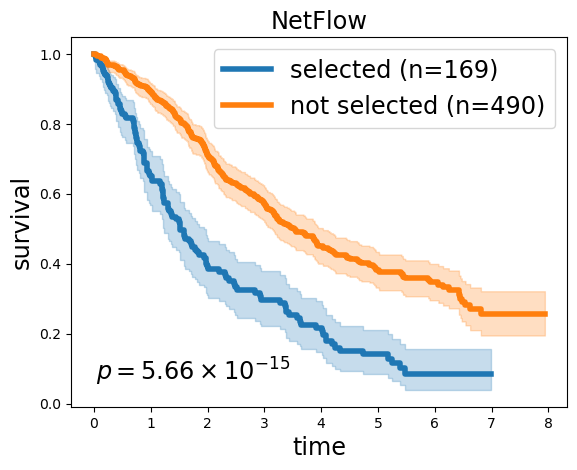

In [32]:
selected = 'MMRF_2828_1_BM_CD138pos, MMRF_1580_1_BM_CD138pos, MMRF_1089_1_BM_CD138pos, MMRF_1927_1_BM_CD138pos, MMRF_1835_1_BM_CD138pos, MMRF_1499_1_BM_CD138pos, MMRF_1715_1_BM_CD138pos, MMRF_2667_1_BM_CD138pos, MMRF_2739_1_BM_CD138pos, MMRF_2394_1_BM_CD138pos, MMRF_2041_1_BM_CD138pos, MMRF_2681_1_BM_CD138pos, MMRF_1700_1_BM_CD138pos, MMRF_2535_1_BM_CD138pos, MMRF_1401_1_BM_CD138pos, MMRF_2818_1_BM_CD138pos, MMRF_2718_1_BM_CD138pos, MMRF_2476_1_BM_CD138pos, MMRF_1539_1_BM_CD138pos, MMRF_1831_1_BM_CD138pos, MMRF_2587_1_BM_CD138pos, MMRF_2200_1_BM_CD138pos, MMRF_1918_1_BM_CD138pos, MMRF_2532_1_BM_CD138pos, MMRF_2194_1_BM_CD138pos, MMRF_2015_1_BM_CD138pos, MMRF_1780_1_BM_CD138pos, MMRF_1641_1_BM_CD138pos, MMRF_2471_1_BM_CD138pos, MMRF_2621_1_BM_CD138pos, MMRF_1338_1_BM_CD138pos, MMRF_2754_1_BM_CD138pos, MMRF_2568_1_BM_CD138pos, MMRF_2225_1_BM_CD138pos, MMRF_1586_1_BM_CD138pos, MMRF_2639_1_BM_CD138pos, MMRF_1992_1_BM_CD138pos, MMRF_1683_1_BM_CD138pos, MMRF_2473_1_BM_CD138pos, MMRF_1541_1_BM_CD138pos, MMRF_1328_1_BM_CD138pos, MMRF_1617_1_BM_CD138pos, MMRF_2801_1_BM_CD138pos, MMRF_2776_1_BM_CD138pos, MMRF_1164_1_BM_CD138pos, MMRF_2452_1_BM_CD138pos, MMRF_2368_1_BM_CD138pos, MMRF_2813_1_BM_CD138pos, MMRF_1627_1_BM_CD138pos, MMRF_1851_1_BM_CD138pos, MMRF_1403_1_BM_CD138pos, MMRF_1677_1_BM_CD138pos, MMRF_1805_1_BM_CD138pos, MMRF_1359_1_BM_CD138pos, MMRF_2847_1_BM_CD138pos, MMRF_2076_1_BM_CD138pos, MMRF_1167_1_BM_CD138pos, MMRF_2272_1_BM_CD138pos, MMRF_1451_1_BM_CD138pos, MMRF_2401_1_BM_CD138pos, MMRF_2531_1_BM_CD138pos, MMRF_2692_1_BM_CD138pos, MMRF_1790_1_BM_CD138pos, MMRF_1819_1_BM_CD138pos, MMRF_2314_1_BM_CD138pos, MMRF_2245_1_BM_CD138pos, MMRF_2017_1_BM_CD138pos, MMRF_1710_1_BM_CD138pos, MMRF_1670_1_BM_CD138pos, MMRF_1727_1_BM_CD138pos, MMRF_2622_1_BM_CD138pos, MMRF_1664_1_BM_CD138pos, MMRF_2026_1_BM_CD138pos, MMRF_1797_1_BM_CD138pos, MMRF_2433_1_BM_CD138pos, MMRF_2746_1_BM_CD138pos, MMRF_2690_1_BM_CD138pos, MMRF_1389_1_BM_CD138pos, MMRF_1689_1_BM_CD138pos, MMRF_1269_1_BM_CD138pos, MMRF_1388_1_BM_CD138pos, MMRF_1822_1_BM_CD138pos, MMRF_1893_1_BM_CD138pos, MMRF_2676_1_BM_CD138pos, MMRF_1300_1_BM_CD138pos, MMRF_2807_1_BM_CD138pos, MMRF_1634_1_BM_CD138pos, MMRF_2436_1_BM_CD138pos, MMRF_1726_1_BM_CD138pos, MMRF_1461_1_BM_CD138pos, MMRF_1771_1_BM_CD138pos, MMRF_2691_1_BM_CD138pos, MMRF_1637_1_BM_CD138pos, MMRF_1971_1_BM_CD138pos, MMRF_2307_1_BM_CD138pos, MMRF_1645_1_BM_CD138pos, MMRF_2335_1_BM_CD138pos, MMRF_1842_1_BM_CD138pos, MMRF_1450_1_BM_CD138pos, MMRF_1534_1_BM_CD138pos, MMRF_1890_1_BM_CD138pos, MMRF_1932_1_BM_CD138pos, MMRF_2788_1_BM_CD138pos, MMRF_2778_1_BM_CD138pos, MMRF_2457_1_BM_CD138pos, MMRF_1424_1_BM_CD138pos, MMRF_2339_1_BM_CD138pos, MMRF_2836_1_BM_CD138pos, MMRF_2608_1_BM_CD138pos, MMRF_2605_1_BM_CD138pos, MMRF_2300_1_BM_CD138pos, MMRF_2251_1_BM_CD138pos, MMRF_2469_1_BM_CD138pos, MMRF_2698_1_BM_CD138pos, MMRF_1453_1_BM_CD138pos, MMRF_2817_1_BM_CD138pos, MMRF_1886_1_BM_CD138pos, MMRF_1644_1_BM_CD138pos, MMRF_1810_1_BM_CD138pos, MMRF_1251_1_BM_CD138pos, MMRF_1432_1_BM_CD138pos, MMRF_1618_1_BM_CD138pos, MMRF_2769_1_BM_CD138pos, MMRF_1833_1_BM_CD138pos, MMRF_1031_1_BM_CD138pos, MMRF_2799_1_BM_CD138pos, MMRF_1286_1_BM_CD138pos, MMRF_2722_1_BM_CD138pos, MMRF_2781_1_BM_CD138pos, MMRF_1169_1_BM_CD138pos, MMRF_2787_1_BM_CD138pos, MMRF_1906_1_BM_CD138pos, MMRF_2574_1_BM_CD138pos, MMRF_2062_1_BM_CD138pos, MMRF_2039_1_BM_CD138pos, MMRF_2290_1_BM_CD138pos, MMRF_2643_1_BM_CD138pos, MMRF_1817_1_BM_CD138pos, MMRF_1671_1_BM_CD138pos, MMRF_1862_1_BM_CD138pos, MMRF_2455_1_BM_CD138pos, MMRF_1595_1_BM_CD138pos, MMRF_1668_1_BM_CD138pos, MMRF_1721_1_BM_CD138pos, MMRF_1879_1_BM_CD138pos, MMRF_2490_1_BM_CD138pos, MMRF_2201_1_BM_CD138pos, MMRF_1082_1_BM_CD138pos, MMRF_2341_1_BM_CD138pos, MMRF_1579_1_BM_CD138pos, MMRF_1364_1_BM_CD138pos, MMRF_1540_1_BM_CD138pos, MMRF_1837_1_BM_CD138pos, MMRF_2458_1_BM_CD138pos, MMRF_1736_1_BM_CD138pos, MMRF_1327_1_BM_CD138pos, MMRF_1682_1_BM_CD138pos, MMRF_2373_1_BM_CD138pos, MMRF_2174_1_BM_CD138pos, MMRF_2119_1_BM_CD138pos, MMRF_2706_1_BM_CD138pos, MMRF_2438_1_BM_CD138pos, MMRF_1755_1_BM_CD138pos, MMRF_2125_1_BM_CD138pos, MMRF_2595_1_BM_CD138pos, MMRF_1596_1_BM_CD138pos, MMRF_1079_1_BM_CD138pos, MMRF_2195_1_BM_CD138pos, MMRF_2211_1_BM_CD138pos'
selected = selected.split(', ')
print(len(selected))

other_samples = list(set(clin.index) - set(selected))

fig, ax = plt.subplots(1, 1) 
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf1.fit(clin.loc[selected, 'T'], event_observed=clin.loc[selected, 'E'], label=f'selected (n={len(selected)})')
kmf2.fit(clin.loc[other_samples, 'T'], event_observed=clin.loc[other_samples, 'E'], label=f'not selected (n={len(other_samples)})')

lr = logrank_test(clin.loc[selected, 'T'], clin.loc[other_samples, 'T'], 
                  event_observed_A=clin.loc[selected, 'E'], event_observed_B=clin.loc[other_samples, 'E'])

kmf1.plot(ax=ax, lw=4)
kmf2.plot(ax=ax, lw=4)

ax.set_title('NetFlow', fontsize='xx-large');
ax.set_xlabel('time', fontsize='xx-large');
ax.set_ylabel('survival', fontsize='xx-large');
ax.legend(loc='upper right', fontsize='xx-large');

lrp = f"{lr.p_value:2.2e}"
if 'e' in lrp:
    lrp = r"$p = {0} \times 10^{{{1}}}$".format(*lrp.split('e'))
else:
    lrp = r"$p = {0}$".format(lrp)

ax.text(0.05, 0.05, lrp, transform=ax.transAxes, 
        ha='left', va='bottom', fontsize='xx-large');# 

# fig.savefig('mm_kmf.png', dpi=300, bbox_inches='tight', transparent=True)

### Panel visualization

First, we collect some NetFlow features and cluster membership data for each observation:

In [33]:
pose_key = 'POSE_1kmnn_3branches_dpt_from_transitions_sym_similarity_max12nn_RNA_nbhd_euc_with_self_WEE1_density_normalized'
gg = keeper.graphs[pose_key]

selected = 'MMRF_2828_1_BM_CD138pos, MMRF_1580_1_BM_CD138pos, MMRF_1089_1_BM_CD138pos, MMRF_1927_1_BM_CD138pos, MMRF_1835_1_BM_CD138pos, MMRF_1499_1_BM_CD138pos, MMRF_1715_1_BM_CD138pos, MMRF_2667_1_BM_CD138pos, MMRF_2739_1_BM_CD138pos, MMRF_2394_1_BM_CD138pos, MMRF_2041_1_BM_CD138pos, MMRF_2681_1_BM_CD138pos, MMRF_1700_1_BM_CD138pos, MMRF_2535_1_BM_CD138pos, MMRF_1401_1_BM_CD138pos, MMRF_2818_1_BM_CD138pos, MMRF_2718_1_BM_CD138pos, MMRF_2476_1_BM_CD138pos, MMRF_1539_1_BM_CD138pos, MMRF_1831_1_BM_CD138pos, MMRF_2587_1_BM_CD138pos, MMRF_2200_1_BM_CD138pos, MMRF_1918_1_BM_CD138pos, MMRF_2532_1_BM_CD138pos, MMRF_2194_1_BM_CD138pos, MMRF_2015_1_BM_CD138pos, MMRF_1780_1_BM_CD138pos, MMRF_1641_1_BM_CD138pos, MMRF_2471_1_BM_CD138pos, MMRF_2621_1_BM_CD138pos, MMRF_1338_1_BM_CD138pos, MMRF_2754_1_BM_CD138pos, MMRF_2568_1_BM_CD138pos, MMRF_2225_1_BM_CD138pos, MMRF_1586_1_BM_CD138pos, MMRF_2639_1_BM_CD138pos, MMRF_1992_1_BM_CD138pos, MMRF_1683_1_BM_CD138pos, MMRF_2473_1_BM_CD138pos, MMRF_1541_1_BM_CD138pos, MMRF_1328_1_BM_CD138pos, MMRF_1617_1_BM_CD138pos, MMRF_2801_1_BM_CD138pos, MMRF_2776_1_BM_CD138pos, MMRF_1164_1_BM_CD138pos, MMRF_2452_1_BM_CD138pos, MMRF_2368_1_BM_CD138pos, MMRF_2813_1_BM_CD138pos, MMRF_1627_1_BM_CD138pos, MMRF_1851_1_BM_CD138pos, MMRF_1403_1_BM_CD138pos, MMRF_1677_1_BM_CD138pos, MMRF_1805_1_BM_CD138pos, MMRF_1359_1_BM_CD138pos, MMRF_2847_1_BM_CD138pos, MMRF_2076_1_BM_CD138pos, MMRF_1167_1_BM_CD138pos, MMRF_2272_1_BM_CD138pos, MMRF_1451_1_BM_CD138pos, MMRF_2401_1_BM_CD138pos, MMRF_2531_1_BM_CD138pos, MMRF_2692_1_BM_CD138pos, MMRF_1790_1_BM_CD138pos, MMRF_1819_1_BM_CD138pos, MMRF_2314_1_BM_CD138pos, MMRF_2245_1_BM_CD138pos, MMRF_2017_1_BM_CD138pos, MMRF_1710_1_BM_CD138pos, MMRF_1670_1_BM_CD138pos, MMRF_1727_1_BM_CD138pos, MMRF_2622_1_BM_CD138pos, MMRF_1664_1_BM_CD138pos, MMRF_2026_1_BM_CD138pos, MMRF_1797_1_BM_CD138pos, MMRF_2433_1_BM_CD138pos, MMRF_2746_1_BM_CD138pos, MMRF_2690_1_BM_CD138pos, MMRF_1389_1_BM_CD138pos, MMRF_1689_1_BM_CD138pos, MMRF_1269_1_BM_CD138pos, MMRF_1388_1_BM_CD138pos, MMRF_1822_1_BM_CD138pos, MMRF_1893_1_BM_CD138pos, MMRF_2676_1_BM_CD138pos, MMRF_1300_1_BM_CD138pos, MMRF_2807_1_BM_CD138pos, MMRF_1634_1_BM_CD138pos, MMRF_2436_1_BM_CD138pos, MMRF_1726_1_BM_CD138pos, MMRF_1461_1_BM_CD138pos, MMRF_1771_1_BM_CD138pos, MMRF_2691_1_BM_CD138pos, MMRF_1637_1_BM_CD138pos, MMRF_1971_1_BM_CD138pos, MMRF_2307_1_BM_CD138pos, MMRF_1645_1_BM_CD138pos, MMRF_2335_1_BM_CD138pos, MMRF_1842_1_BM_CD138pos, MMRF_1450_1_BM_CD138pos, MMRF_1534_1_BM_CD138pos, MMRF_1890_1_BM_CD138pos, MMRF_1932_1_BM_CD138pos, MMRF_2788_1_BM_CD138pos, MMRF_2778_1_BM_CD138pos, MMRF_2457_1_BM_CD138pos, MMRF_1424_1_BM_CD138pos, MMRF_2339_1_BM_CD138pos, MMRF_2836_1_BM_CD138pos, MMRF_2608_1_BM_CD138pos, MMRF_2605_1_BM_CD138pos, MMRF_2300_1_BM_CD138pos, MMRF_2251_1_BM_CD138pos, MMRF_2469_1_BM_CD138pos, MMRF_2698_1_BM_CD138pos, MMRF_1453_1_BM_CD138pos, MMRF_2817_1_BM_CD138pos, MMRF_1886_1_BM_CD138pos, MMRF_1644_1_BM_CD138pos, MMRF_1810_1_BM_CD138pos, MMRF_1251_1_BM_CD138pos, MMRF_1432_1_BM_CD138pos, MMRF_1618_1_BM_CD138pos, MMRF_2769_1_BM_CD138pos, MMRF_1833_1_BM_CD138pos, MMRF_1031_1_BM_CD138pos, MMRF_2799_1_BM_CD138pos, MMRF_1286_1_BM_CD138pos, MMRF_2722_1_BM_CD138pos, MMRF_2781_1_BM_CD138pos, MMRF_1169_1_BM_CD138pos, MMRF_2787_1_BM_CD138pos, MMRF_1906_1_BM_CD138pos, MMRF_2574_1_BM_CD138pos, MMRF_2062_1_BM_CD138pos, MMRF_2039_1_BM_CD138pos, MMRF_2290_1_BM_CD138pos, MMRF_2643_1_BM_CD138pos, MMRF_1817_1_BM_CD138pos, MMRF_1671_1_BM_CD138pos, MMRF_1862_1_BM_CD138pos, MMRF_2455_1_BM_CD138pos, MMRF_1595_1_BM_CD138pos, MMRF_1668_1_BM_CD138pos, MMRF_1721_1_BM_CD138pos, MMRF_1879_1_BM_CD138pos, MMRF_2490_1_BM_CD138pos, MMRF_2201_1_BM_CD138pos, MMRF_1082_1_BM_CD138pos, MMRF_2341_1_BM_CD138pos, MMRF_1579_1_BM_CD138pos, MMRF_1364_1_BM_CD138pos, MMRF_1540_1_BM_CD138pos, MMRF_1837_1_BM_CD138pos, MMRF_2458_1_BM_CD138pos, MMRF_1736_1_BM_CD138pos, MMRF_1327_1_BM_CD138pos, MMRF_1682_1_BM_CD138pos, MMRF_2373_1_BM_CD138pos, MMRF_2174_1_BM_CD138pos, MMRF_2119_1_BM_CD138pos, MMRF_2706_1_BM_CD138pos, MMRF_2438_1_BM_CD138pos, MMRF_1755_1_BM_CD138pos, MMRF_2125_1_BM_CD138pos, MMRF_2595_1_BM_CD138pos, MMRF_1596_1_BM_CD138pos, MMRF_1079_1_BM_CD138pos, MMRF_2195_1_BM_CD138pos, MMRF_2211_1_BM_CD138pos'
selected = selected.split(', ')

record = pd.DataFrame({k: dict(gg.nodes.data(k)) for k in ['name', 'branch', 'branch-louvain0x1', 'louvain0x1']}).set_index('name')
record = record.rename(columns={'louvain0x1': 'Louvain', 'branch-louvain0x1': 'BL-clusters'})

record['BL-clusters'] = record['BL-clusters'].map(dict(zip(sorted(record['BL-clusters'].unique()), range(record['BL-clusters'].nunique()))))
record['risk'] = ['higher' if k in set(selected) else 'lower' for k in record.index]
record

# clin_g[['NF_selected']].to_csv(NETFLOW_RESULTS_DIR / 'netflow_selected_samples_POSE_1kmnn_5branches_dpt_from_transitions_sym_similarity_max5nn_WEE1_RNA_nbhd_euc_with_self_density_normalize.csv', header=True, index=True)

branch  BL-clusters  Louvain    risk
name                                                         
MMRF_2368_1_BM_CD138pos       0            1        2  higher
MMRF_1461_1_BM_CD138pos       0            1        2  higher
MMRF_2245_1_BM_CD138pos       0            1        2  higher
MMRF_1797_1_BM_CD138pos       0            1        2  higher
MMRF_2433_1_BM_CD138pos       0            1        2  higher
...                         ...          ...      ...     ...
MMRF_2761_1_BM_CD138pos       9           18        3   lower
MMRF_1917_1_BM_CD138pos       9           18        3   lower
MMRF_2638_1_BM_CD138pos       9           18        3   lower
MMRF_2815_1_BM_CD138pos       9           18        3   lower
MMRF_1180_1_BM_CD138pos       9           18        3   lower

[659 rows x 4 columns]

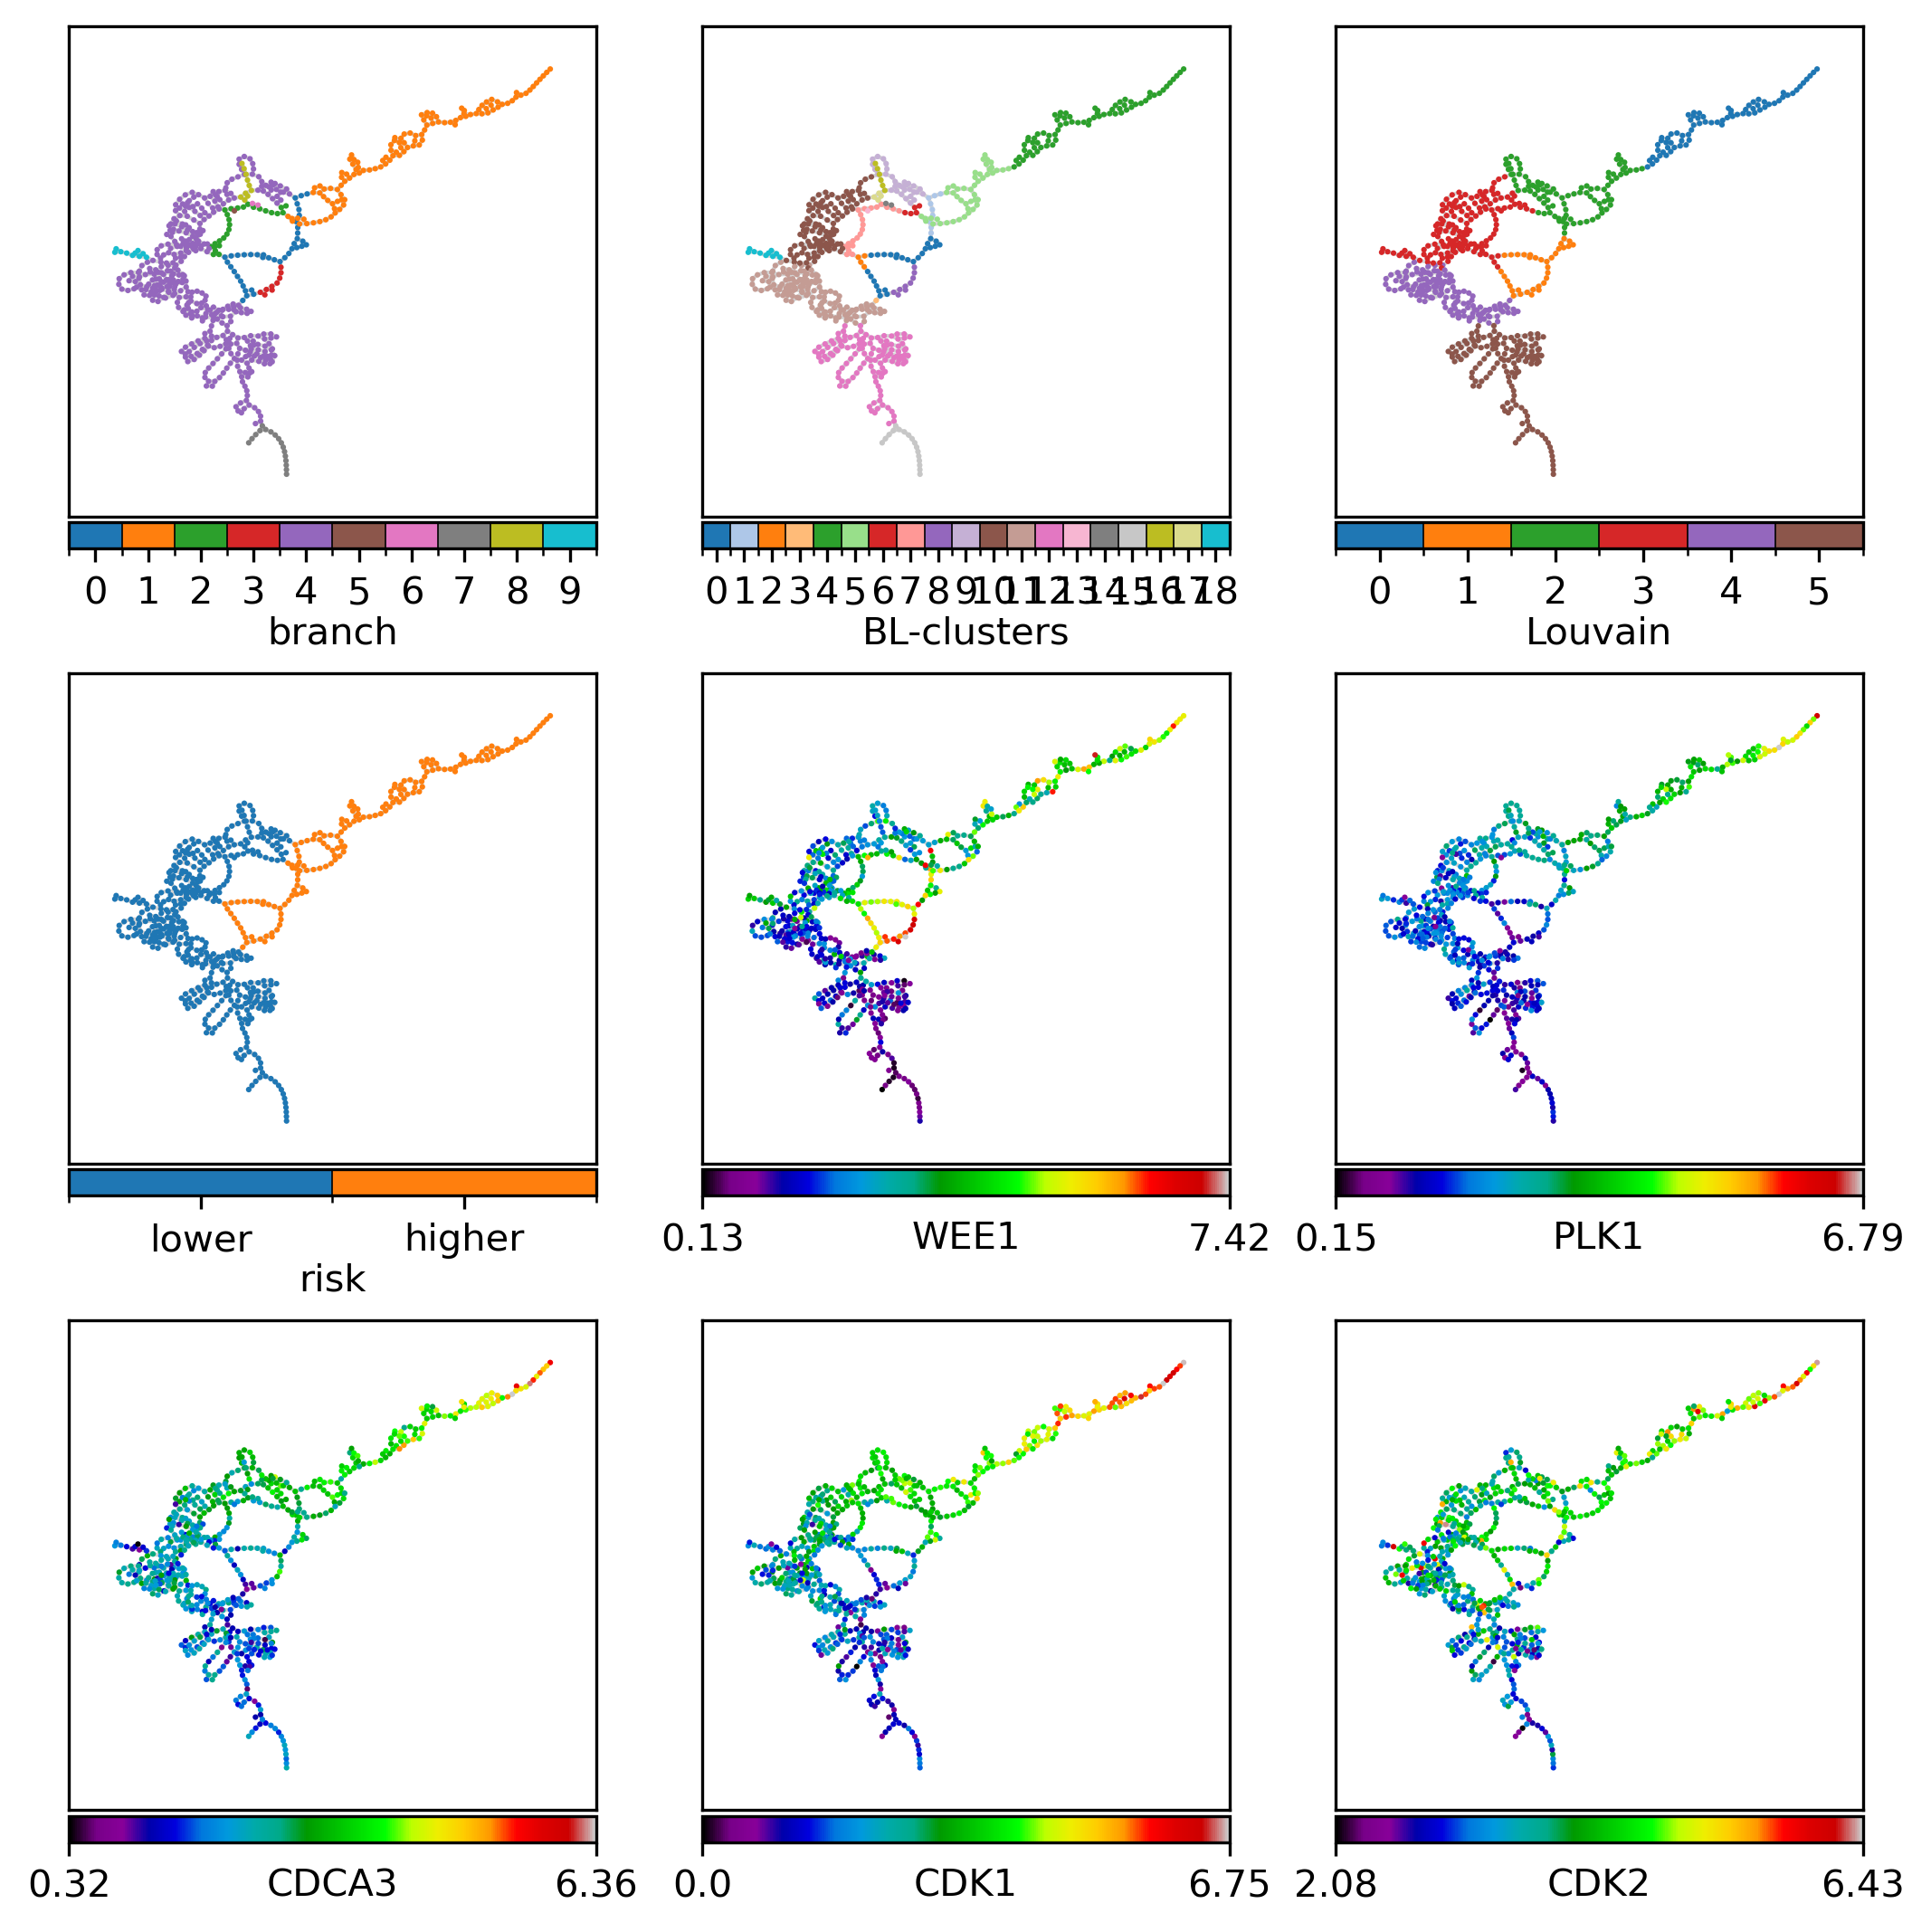

In [34]:
s = selected
s = None

nodelist = list(gg)
pos = nx.layout.kamada_kawai_layout(gg)


if s is None:
    border_linewidths = 0
else:
    s_names = {gg.nodes[k]['name']: k for k in gg}
    s = set([s_names[k] for k in s])
    border_linewidths = [0.24 if k in s else 0. for k in nodelist]  # : scalar or sequence (default=1.0) 
bordercolors = 'k'


fts = pd.concat([record.replace({'risk': {'higher': 1, 'lower': 0}}), 
                 keeper.data['RNA'].subset(features=['WEE1',  'PLK1', 'CDCA3', 'CDK1', 'CDK2']).T], axis=1)
fts = fts.rename(index={gg.nodes[k]['name']: k for k in gg})
fts = fts.loc[nodelist]

fig, axes = plt.subplots(3, 3, figsize=(7, 7), layout='constrained', dpi=300)
for (ft_label, ft), ax in zip(fts.iteritems(), np.ravel(axes)):
    if ft_label in ['Louvain', 'BL-clusters', 'branch']:
        node_cmap = 'tab10' if ft.nunique() <= 10 else 'tab20' if ft.nunique() <= 20 else 'nipy_spectral'
        ntm= None
    elif ft_label == 'risk':
        node_cmap = 'tab10' 
        ntm = {0: 'lower', 1: 'higher'}
    else:
        node_cmap = 'nipy_spectral'
        ntm = None
    nfv.plot_topology(gg, pos=pos, ax=ax, nodelist=nodelist, node_size=2.2, # 4.3, # 2.3, 
                      node_color=ft.values, edge_color='lightgray', node_cbar=True, 
                      node_cbar_kws={'location': 'bottom', 'orientation': 'horizontal', 'pad': 0.01},
                      node_cbar_label=ft_label, 
                      node_cmap=node_cmap,
                      node_ticklabels_mapper=ntm,
                      border_linewidths=border_linewidths, bordercolors=bordercolors,
                     )

Visualization annotating selected samples:

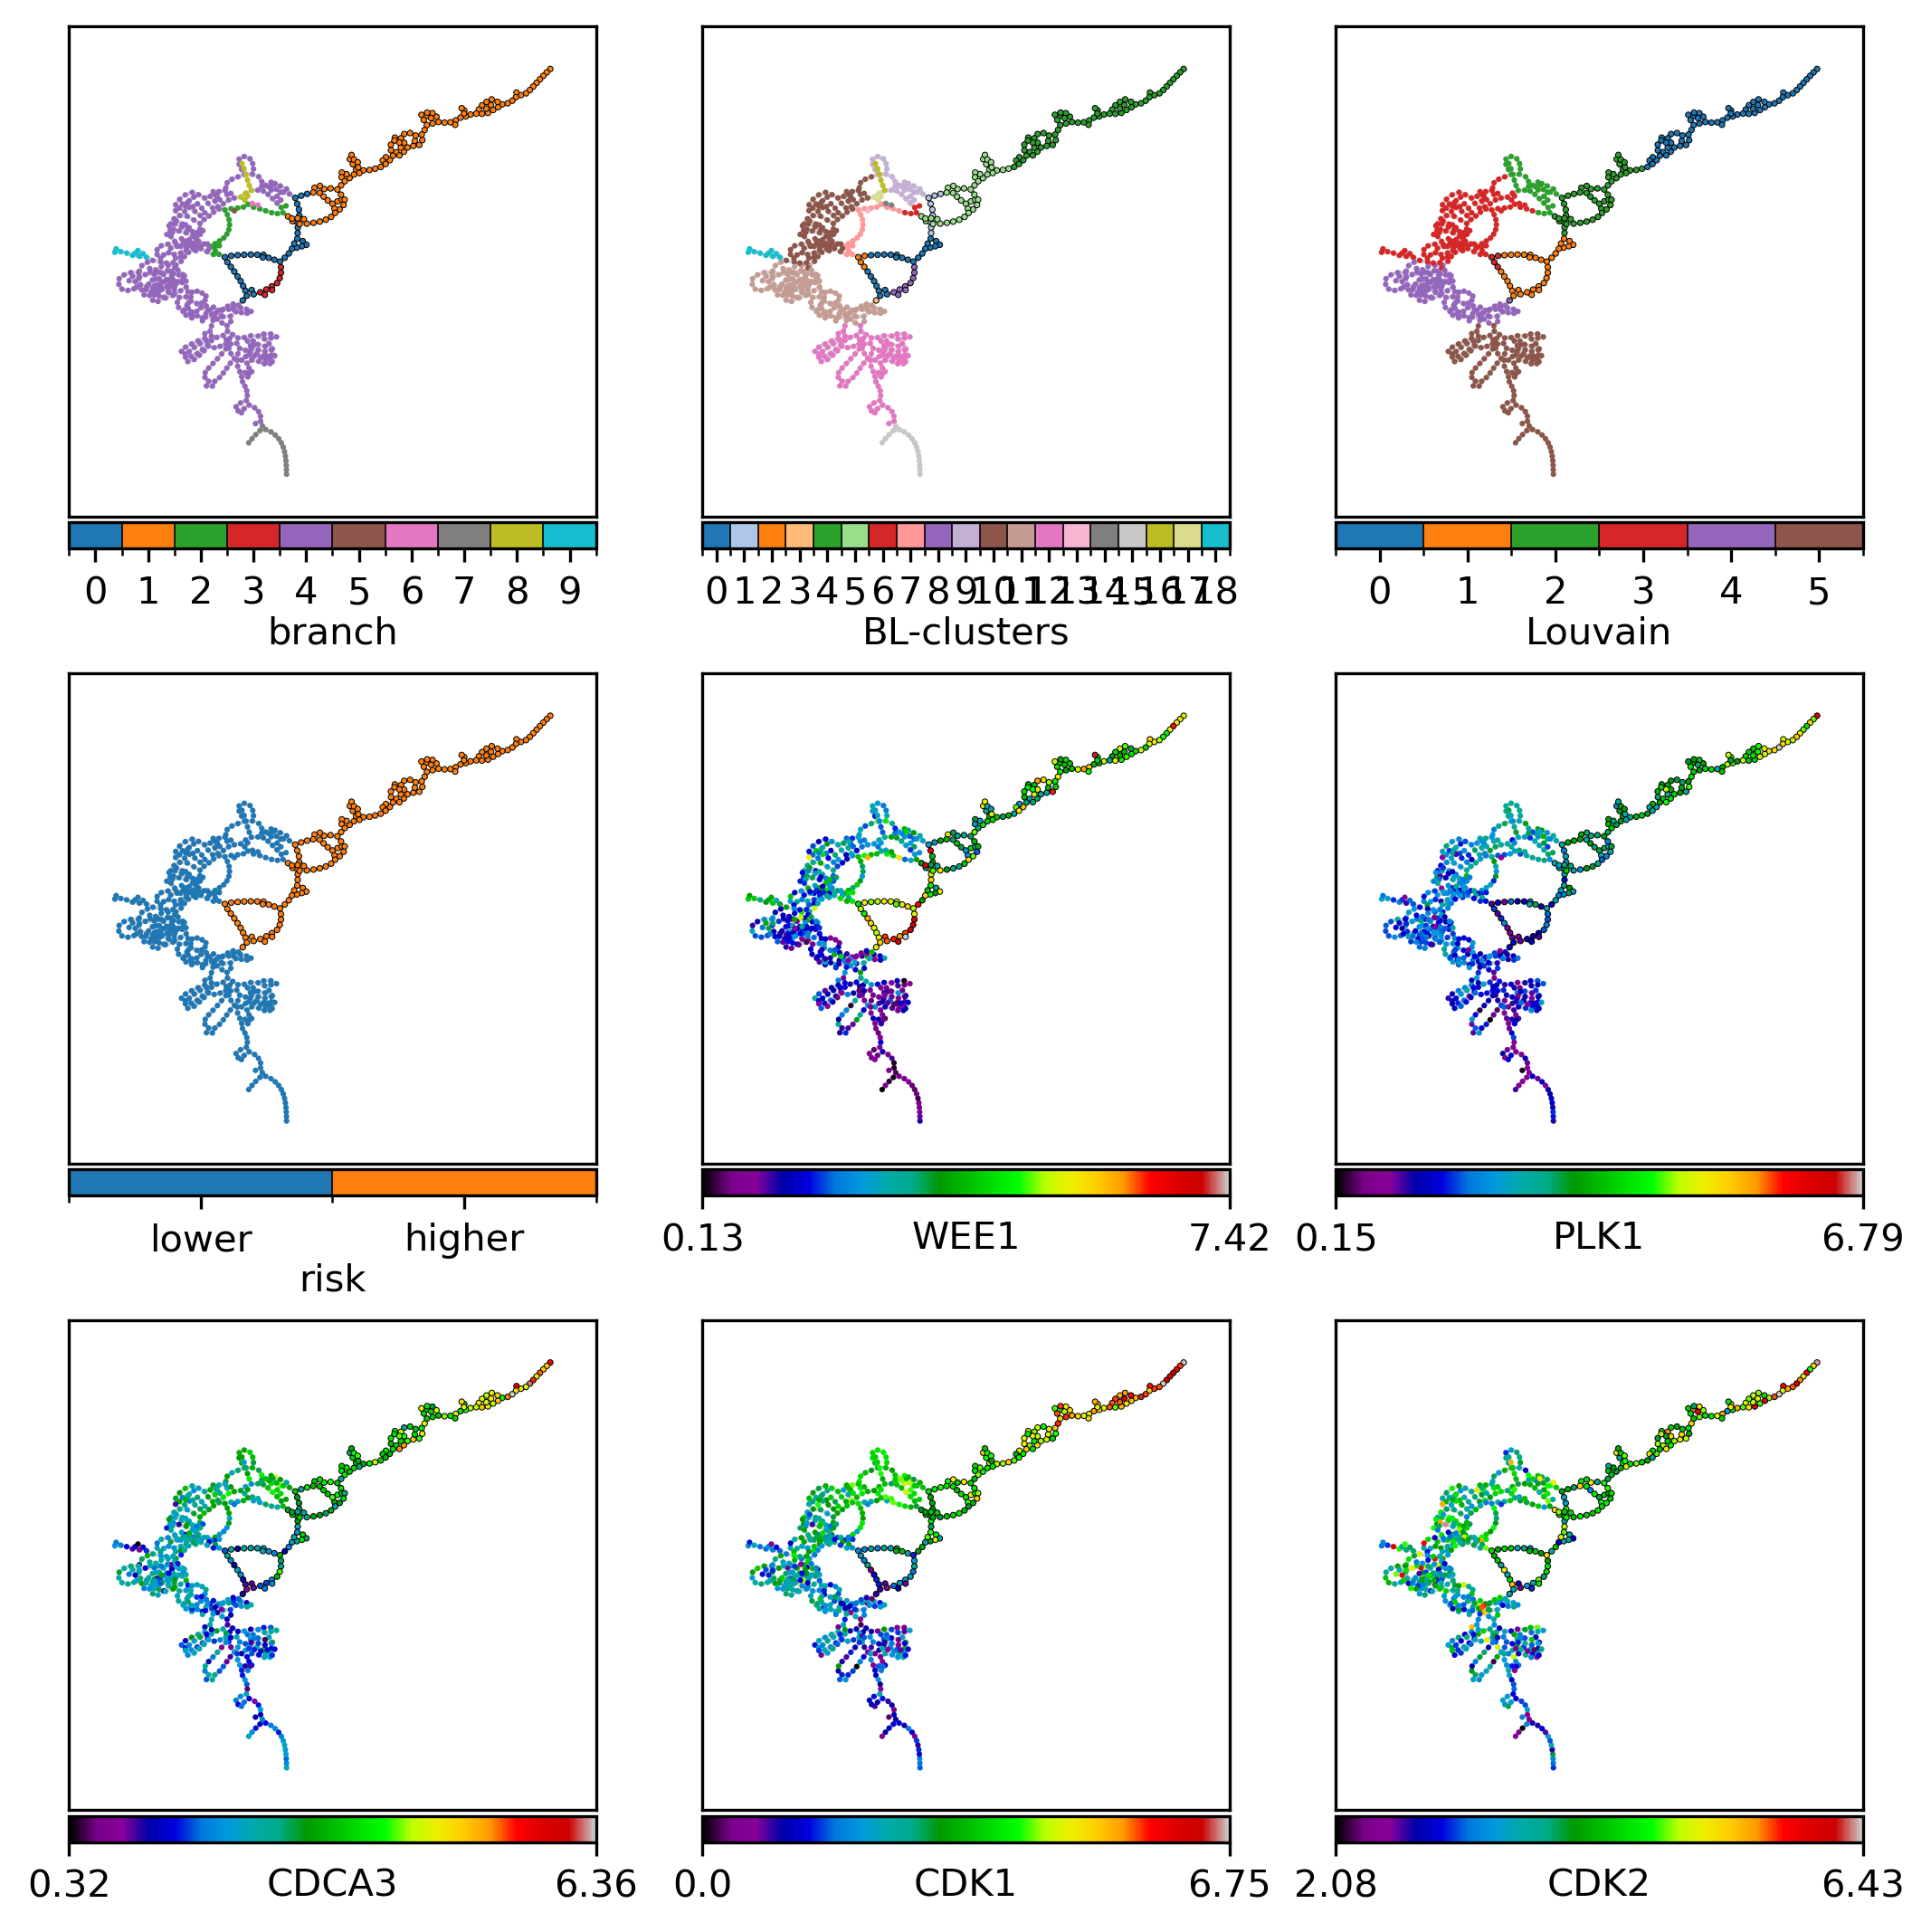

In [35]:
s = selected
# s = None

nodelist = list(gg)
pos = nx.layout.kamada_kawai_layout(gg)


if s is None:
    border_linewidths = 0
else:
    s_names = {gg.nodes[k]['name']: k for k in gg}
    s = set([s_names[k] for k in s])
    border_linewidths = [0.24 if k in s else 0. for k in nodelist]  # : scalar or sequence (default=1.0) 
bordercolors = 'k' # ['k' if k in s else cc for k, cc in zip(nl, nc)] # [None | scalar | sequence] (default = node_color)                    


fts = pd.concat([record.replace({'risk': {'higher': 1, 'lower': 0}}), 
                 keeper.data['RNA'].subset(features=['WEE1',  'PLK1', 'CDCA3', 'CDK1', 'CDK2', 
                                          # 'ATAD2', 'SPAG5', 'RAD21', 'MCM4', 
                                          # 'GABARAPL1', 'RALGDS', 'SNUPN', 'CHIC2', 'FARSA',
                                         ]).T], axis=1)
fts = fts.rename(index={gg.nodes[k]['name']: k for k in gg})
fts = fts.loc[nodelist]

# fig, axes = plt.subplots(1, 6, figsize=(13, 2.5), layout='constrained', dpi=300)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), layout='constrained', dpi=300)


for (ft_label, ft), ax in zip(fts.iteritems(), np.ravel(axes)):
    if ft_label in ['Louvain', 'BL-clusters', 'branch']:
        node_cmap = 'tab10' if ft.nunique() <= 10 else 'tab20' if ft.nunique() <= 20 else 'nipy_spectral'
        ntm= None
    elif ft_label == 'risk':
        node_cmap = 'tab10' 
        ntm = {0: 'lower', 1: 'higher'}
    else:
        node_cmap = 'nipy_spectral'
        ntm = None
    nfv.plot_topology(gg, pos=pos, ax=ax, nodelist=nodelist, node_size=2.2, # 4.3, # 2.3, 
                      node_color=ft.values, edge_color='lightgray', node_cbar=True, 
                      node_cbar_kws={'location': 'bottom', 'orientation': 'horizontal', 'pad': 0.01},
                      node_cbar_label=ft_label, 
                      node_cmap=node_cmap,
                      node_ticklabels_mapper=ntm,
                      border_linewidths=border_linewidths, bordercolors=bordercolors,
                     )